# Introduction

This is a bioinformatic algorithm to prefict the origin of replication of circular genomes. It is based on the lectures by [Prof. Pavel Pevzner](https://www.coursera.org/learn/bioinformatics).

[GC-skew](https://en.wikipedia.org/wiki/GC_skew) reaches a minimum around the origin of replication (although the evolutionary mechanisms underlying this is [disputed](https://www.ncbi.nlm.nih.gov/pubmed/17646257)). We leverge this as an estimate of the location of the oriC (origin of replication). About this, we scan for motifs which are, in fact, are DnaA monomers, [which specify the helicase binding site](https://www.ncbi.nlm.nih.gov/pubmed/11316803). To do so, we search for a the __consesus sequence__ to these DNA monomers; the highest concentration of these sequences similar to this consesus sequence is likely to be the oriC. We will see, this approach yields a consensus sequence with seven hits, three of which are directly in the 312 bp region formally defined as the oriC.

It should be noted, __consesus sequences__ are not necessarily present in the genome. Rather, they represent a sequence with which the greatest number of k-mers (i.e. k-length DNA polymers) have the smallest [hamming distance](https://en.wikipedia.org/wiki/Hamming_distance). The reader is likely more familiar with a sequence logo:

![Imgur](https://i.imgur.com/BahU1P8.png)

This algorithm does not calculate the logo. It does, however, capture the same sequence that can be read by taking the top base pair from each position in the logo. For example, from the sequence represented in the above logo, our algorithm would capture ````TTTCGCAAT````.

To simply the problem, we focus on a small set of computational challenges. Namely:
* How to calculate the GC-skew curve and determine its global mimima
* How to determine the best consensus sequence for motifs around this minimum.
This method is frequently used to predict the oriC.

This leaves out a number of other issues, such as:
* How to determine how large a window to scan for consensus sequences around the oriC
* How to determine the length of the oriC
* How to determine how many mismatches (mutations) are allowed before two sequences are considered distinct

These issues, we leave as parameters for the researcher to tweak. The goal, of course, is attempt to recapitulate experimentall validated results.

# Settings and import dependencies

In [1]:
window_length = 1000
k_mer_length = 9
max_mismatches_allowed = 1
genome_fp = 'E_coli_genome.fas'

import regex
from pandas import DataFrame
from collections import defaultdict
from os.path import isfile
from urllib.request import urlretrieve
%matplotlib inline

# Declare helper functions

There are a few functions and mappings that we will need, but are peripheral to our main goal: determining a consensus sequence for the oriC.

We  define them here, but do not discuss them at length. The reader should feel free to skip them.

In [2]:
def flatten(l):
    '''
    Flatten a nestled list
    '''
    out = []
    for item in l:
        if isinstance(item, (list, tuple)):
            out.extend(flatten(item))
        else:
            out.append(item)
    return out


def reverse_complement(sequence):
    '''
    Returns the reverse complement of the sequence
    '''
    complement = {'C': 'G',
                  'G': 'C',
                  'T': 'A',
                  'A': 'T',
                  'N': 'N'}
    try:
        return ''.join(complement[bp] for bp in reversed(sequence))
    except KeyError:
        raise Exception('Attempted to find the complement of a base pair that is not A, C, G, T or N.')
        
class Subsequences:
    '''
    Subsequences is an iterator that iterates over all
    possible polymers of a defined length within a sequence
    '''
    def __init__(self, _sequence, _kmer_length):
        self.sequence = _sequence
        self.k = _kmer_length
        self.pos = 0

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.sequence) - self.k + 1

    def __getitem__(self, item):
        return self.sequence[item:item+self.k]

    def __next__(self):
        if self.pos < len(self.sequence) - self.k:
            self.pos += 1
            return self.sequence[self.pos:self.pos+self.k]
        else:
            raise StopIteration

# Read genome, calculate the GC skew curve and plot it

In [3]:
if not isfile(genome_fp):
    urlretrieve('https://www.genome.wisc.edu/pub/sequence/U00096.2.fas', genome_fp)

with open(genome_fp, 'r') as f:
    # Load genome as FASTA file
    genome = ''.join(line.strip().upper() for line in f if not line.startswith('>'))

df = DataFrame({'Nucleotide': list(genome)})
nucleotide_to_delta_skew = {'A': 0,
                        'C': -1,
                        'T': 0,
                        'G': 1,
                        'N': 0}
df['Delta_Skew'] = df.Nucleotide.apply(lambda n: nucleotide_to_delta_skew[n])
df['Skew'] = df['Delta_Skew'].cumsum()
df.head(10)

,Nucleotide,Delta_Skew,Skew
0,A,0,0
1,G,1,1
2,C,-1,0
3,T,0,0
4,T,0,0
5,T,0,0
6,T,0,0
7,C,-1,-1
8,A,0,-1
9,T,0,-1


Text(0,0.5,'Skew')

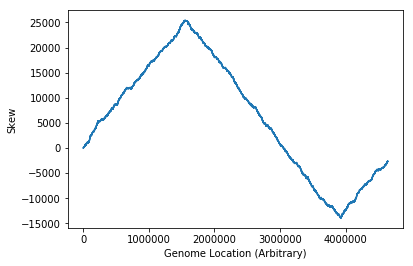

In [4]:
ax = df['Skew'].plot()
ax.set_xlabel("Genome Location (Arbitrary)")
ax.set_ylabel("Skew")

There is a clear GC skew minimum.

# Calculate the precise minimum

This is simple in Pandas:

In [5]:
minimum_skew = df['Skew'].min()
minimum_skew_locations = [int(l) for l in df[df['Skew'] == minimum_skew].index \
                          if df.loc[l]['Delta_Skew'] == -1]

Now that we know where in the genome to took, we need three more functions.
1. To return a subset or 'window' of the genome around the GC skew minimum
1. Find all k-mers and sequences that are closely related (by an arbitrary number of mutations) to these k-mers, which we call in its totality the "sequence neighborhood"
1. Scan for the most frequent sequence in this "sequence neighborhood" within this window

### Return a subset centered around the GC skew minimum
For (1), this is a simple splice:

In [6]:
def window_centered_around(_center, _window_length, _genome):    
    return _genome[int(_center - _window_length / 2):int(_center + (_window_length / 2))]

### Generate the sequence neighborhood

For (2), this is somewhat more complicated. We'll handle this recursively, starting with the base case. Here, we take a single sequence. We iterate over each nucleotide in this sequence, substituting it with all other nucleotides, and adding the result to a set. (The set data structure automatically filters out duplicates.)

In [7]:
substitutes = {'A': ['C', 'T', 'G'],
               'T': ['A', 'C', 'G'],
               'G': ['A', 'T', 'C'],
               'C': ['A', 'T', 'G'],
               'N': ['C', 'A', 'T', 'G']}

def sequences_with_one_mismatch(base_sequence):
    '''
    Returns all sequences that could occur with one point mutation of the given base sequence
    '''
    sequences = [base_sequence]

    for i, nucleotide in enumerate(base_sequence):
        for substitute_nucleotide in substitutes[nucleotide]:
            new_neighbor = base_sequence[:i] + substitute_nucleotide + base_sequence[i + 1:]
            sequences.append(new_neighbor)

    return sequences

With this base case implemented, we now must create a function to apply it an arbitrary number of times to generate the full sequence neighborhood.

In [8]:
def sequence_neighborhood(base_sequence, max_mismatches_allowed):
    '''
    Returns a 'neighborhood' of sequences where there are a defined
    number of mismatches with the seed sequence
    '''

    neighborhood = {base_sequence} # We filter out redundant sequences by using a set as the data structure

    for i in range(max_mismatches_allowed):
        new_neighbors = [sequences_with_one_mismatch(neighbor) for neighbor in neighborhood]
        neighborhood.update(flatten(new_neighbors))

    return list(neighborhood)

### Scan for the most frequent K-mers

At this point, we have all kmers and related sequences that _could_ form a consensus sequence. Now, we need to find which of these occurs the most.

Note, we define 'occur' here as having at most an arbitrary number of mismatches with a k-mer actually present in the genome. Thus, we need a function to count the number of approximate matches between two sequences.

In [9]:
def num_approx_matches(_in_sequence, _of_kmer, max_mismatches_allowed):
    '''
    Compares two sequence and returns the number of times there is an
    aproximate match, defined by having at most a defined number of
    mismatches
    '''
    search_expression = '(%s){s<=%s}' % (_of_kmer, max_mismatches_allowed)
    occurrences = regex.findall(search_expression, _in_sequence)
    return len(occurrences)

Finally, we pull these functions together.

In [10]:
def most_frequent_kmers(_sequence, _k_mer_length, _max_mismatches):
    '''
    Returns the kmers with the greatest number of hits and the
    number of those hits
    '''
        
    possible_kmers = set()

    for sequence in Subsequences(_sequence, _k_mer_length):
        possible_kmers.update(sequence_neighborhood(sequence, _max_mismatches))

    k_mer_hits = defaultdict(list)
    
    for kmer in possible_kmers:
        forward_hits = num_approx_matches(_sequence, kmer, _max_mismatches)
        reverse_complement_hits = num_approx_matches(_sequence, reverse_complement(kmer), _max_mismatches)
        k_mer_hits[forward_hits + reverse_complement_hits].append(kmer)
        
    number_of_top_hits = max(k_mer_hits.keys())
    top_hits = k_mer_hits[number_of_top_hits]
    
    return number_of_top_hits, top_hits

With these functions defined, we may iterate over the windows centered around these GC skew minimums and search for aproximate matches. The k-mer with the most matches likely indicates the region of the origin of replication.

In [11]:
for min_skew_loc in minimum_skew_locations:
    window = window_centered_around(min_skew_loc, window_length, genome)
    number_of_top_hits, top_hits = most_frequent_kmers(window, k_mer_length, max_mismatches_allowed)
    
    print(f'Searched the following window centered around {min_skew_loc} bp:\n\n{window}\n')
    
    if(number_of_top_hits > 0):
        print(f'Found the following motifs:')
        for hit in top_hits:
            print(f'\t* {hit} [{number_of_top_hits} hits]')
    else:
        print('Found nothing.')

Searched the following window centered around 3923619 bp:

CGGCGGATCACCAGCACGGCCACCGCTGTAATTATCCAGACCGATATGAATTTTACCGTCGAGGAACGTCCCAACGGTGAGCACGACGGCTTTGGCACGGAACTTCAGTCCCATTTGGGTAACAGCACCGACCACGCGATCGTTTTCGACAATAAGATCTTCAACCGCCTGCTGGAAGATCATCAGGTTCGGTTGGTTCTCCAGCGCCGTACGTACCGCCTGACGGTAGAGCACACGATCCGCCTGAGCTCGGGTAGCGCGAACCGCCGGTCCTTTGCTTGCGTTTAGTATCCTAAACTGGATACCCGCCTGATCGATCGCTTTCGCCATCAGACCGCCGAGTGCATCCACTTCTTTTACCAGATGTCCCTTCCCAATACCGCCGATCGCCGGGTTGCAGCTCATCTGCCCCAGAGTGTCGATATTGTGTGTCAAAAGCAGAGTCTGTTGACCCATACGCGCCGCGGCCATCGCGGCCTCGGTGCCTGCATGACCCCCGCCAATGATGATGACGTCAAAAGGATCCGGATAAAACATGGTGATTGCCTCGCATAACGCGGTATGAAAATGGATTGAAGCCCGGGCCGTGGATTCTACTCAACTTTGTCGGCTTGAGAAAGACCTGGGATCCTGGGTATTAAAAAGAAGATCTATTTATTTAGAGATCTGTTCTATTGTGATCTCTTATTAGGATCGCACTGCCCTGTGGATAACAAGGATCCGGCTTTTAAGATCAACAACCTGGAAAGGATCATTAACTGTGAATGATCGGTGATCCTGGACCGTATAAGCTGGGATCAGAATGAGGGGTTATACACAACTCAAAAACTGAACAACAGTTGTTCTTTGGATAACTACCGGTTGATCCAAGCTTCCTGACAGAGTTATCCACAGTAGATCGCACGATCTGTATACTTATTTGAGTAAATTAACCCACGATC

Indeed, if the sample genome was used, this is the origin of replication for _E. coli_ as shown [here](https://www.ncbi.nlm.nih.gov/projects/sviewer/?id=AC_000091.1&v=3710170..3711547&m=3710670,3711047). __Bolded__ are the DnaA boxes we found, although only three are directly in the 312 bp region formally defined as the oriC.
<pre>
    >gi|89106884|ref|AC_000091.1|:3710692-3711004 Escherichia coli str. K-12 substr. W3110, complete genome
    TGTGGATAACTCTGTCAGGAAGCTTGGATCAACCGGTAGTTATCCAAAGAACAACTGTTGTTCAGTTTTT
    TGTGGATAACTCTGTCAGGAAGCTTG<b>GATCAACCG</b>GTAGTTATCCAAAGAACAACTGTTGTTCAGTTTTT
    GAGTTGTGTATAACCCCTCATTCTGATCCCAGCTTATACGGTCCAGGATCACCGATCATTCACAGTTAAT
    GATCCTTTCCAGG<b>TTGTTGATC</b>TTAAAAGCCGGATCCTTGT<b>TATCCACAG</b>GGCAGTGCGATCCTAATAAG
    AGATCACAATAGAACAGATCTCTAAATAAATAGATCTTCTTTTTAATACCCAGGATCCCAGGTCTTTCTC
    AAGCCGACAAAGTTGAGTAGAATCCACGGCCCG
</pre>